In [1]:
import pandas as pd
import json
import  tarfile
import bz2
import os
from nltk.tokenize import TweetTokenizer
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from collections import Counter
from sklearn.feature_extraction.text import CountVectorizer
from nltk import agreement
import statsmodels.formula.api as smf
sns.set_style('whitegrid')
%matplotlib inline
import random
import math

import multiprocessing
import json
import os
import re
import datetime
import time
import pprint
from datetime import datetime
from datetime import timedelta
import pytz
import glob
from random import sample
import pickle
from datetime import date, timedelta

In [2]:
files = []
for i in range(40):
    files.append("derived_dataset/lengths_derived_dataset_batch_"+str(i+1)+".parquet")

In [3]:
def process_batch(file):
    df = pd.read_parquet(file)
    d = datetime(2019, 11, 1,0,0,0)
    
    df_stats = {}
    df_stats['lang'] = df['lang'].value_counts()
    df_stats['source'] = df['source'].value_counts()
    df_stats['user_n_tweets'] = df['user_n_tweets'].value_counts()
    df_stats['user_n_followers'] = df['user_n_followers'].value_counts()
    df_stats['user_n_following'] = df['user_n_following'].value_counts()
    df_stats['user_age_weeks'] = pd.DataFrame((pd.DataFrame([d]*len(df)).values[0] - df['user_created_at'].values))\
    [0].apply(lambda x: math.floor(x.days/7)).value_counts()

    return df_stats

In [4]:
p = multiprocessing.Pool(10)
print('Parallelized on number of cores:',multiprocessing.cpu_count())

start = time.time()

output = p.map(process_batch, files)

p.close()
p.join()

end = time.time()
elapsed = end - start

print('Elapsed time:',time.strftime("%H:%M:%S", time.gmtime(elapsed)))

Parallelized on number of cores: 48
Elapsed time: 00:20:57


In [6]:
stats_dict = {}

for item in output:
    for cnt,d in enumerate(item.keys()):
        if d not in stats_dict.keys():
            stats_dict[d] = item[d]
        else:
            stats_dict[d] = stats_dict[d].add(item[d], fill_value=0)

In [7]:
df_stats = pd.DataFrame(stats_dict).T

### Make histograms

In [9]:
mapping_lang_codes = {}
mapping_lang_codes['ja'] = 'Japanese'
mapping_lang_codes['en'] = 'English'
mapping_lang_codes['pt'] = 'Portuguese'
mapping_lang_codes['es'] = 'Spanish'
mapping_lang_codes['ar'] = 'Arabic'
mapping_lang_codes['ko'] = 'Korean'
mapping_lang_codes['in'] = 'Indonesian'
mapping_lang_codes['tl'] = 'Tagalog'
mapping_lang_codes['tr'] = 'Turkish'
mapping_lang_codes['fr'] = 'French'
mapping_lang_codes['th'] = 'Thai'
mapping_lang_codes['ru'] = 'Russian'
mapping_lang_codes['it'] = 'Italian'
mapping_lang_codes['de'] = 'German'
mapping_lang_codes['pl'] = 'Polish'
mapping_lang_codes['hi'] = 'Hindi'
mapping_lang_codes['fa'] = 'Persian'
mapping_lang_codes['nl'] = 'Dutch'
mapping_lang_codes['ht'] = 'Haitian Creole'
mapping_lang_codes['et'] = 'Estonian'
mapping_lang_codes['zh'] = 'Chinese'
mapping_lang_codes['ur'] = 'Urdu'
mapping_lang_codes['sv'] = 'Swedish'

In [98]:
cs = ['tab:blue',
 'tab:orange',
 'tab:orange',
 'tab:orange',
 'tab:orange',
 'tab:blue',
 'tab:orange',
 'tab:orange',
 'tab:orange',
 'tab:orange',
 'tab:orange',
 'tab:orange',
 'tab:orange',
 'tab:orange',
 'tab:orange',
 'tab:orange',
 'tab:orange',
 'tab:orange',
 'tab:orange',
 'tab:orange',
 'tab:blue',
 'tab:orange',
 'tab:orange']

In [99]:
len(cs)

23

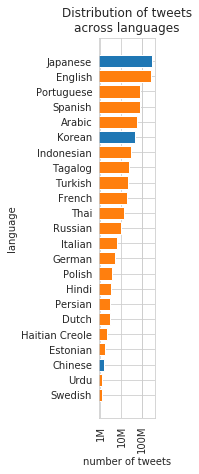

In [100]:
fig,ax = plt.subplots(1,1,figsize= (1,7))

plt.barh(range(23),stats_dict['lang'].loc[stats_dict['lang'].index!='und'].sort_values(ascending = True)[-23:].values, color = cs[::-1])
plt.yticks(range(23),
           [mapping_lang_codes[i] for i in stats_dict['lang'].\
            loc[stats_dict['lang'].index!='und'].\
            sort_values(ascending = True)[-23:].index], rotation = 0)
plt.xscale('log')
plt.xticks([1000000,10000000,100000000,100000000],['1M','10M','100M'], rotation = 90)
plt.ylabel('language')
plt.xlabel('number of tweets')

plt.title('Distribution of tweets\nacross languages')


plt.savefig("langs.pdf", bbox_inches='tight')

In [218]:
list_languages = list({k: v for k, v in sorted(mapping_lang_codes.items(),
                                               key=lambda item: item[1])}.keys())

In [219]:
list_languages

['ar',
 'zh',
 'nl',
 'en',
 'et',
 'fr',
 'de',
 'ht',
 'hi',
 'in',
 'it',
 'ja',
 'ko',
 'fa',
 'pl',
 'pt',
 'ru',
 'es',
 'sv',
 'tl',
 'th',
 'tr',
 'ur']

### Source interpretation:

1. Mobile:

    1. ">Twitter for iPhone<"
    <a href="http://twitter.com/download/iphone" rel="nofollow">Twitter for iPhone</a>
    2. ">Twitter for Android<"
    <a href="http://twitter.com/download/android" rel="nofollow">Twitter for Android</a>
    3. ">Twitter for iPad<"
    <a href="http://twitter.com/#!/download/ipad" rel="nofollow">Twitter for iPad</a>
    4. ">Mobile Web (M2)<"
    <a href="https://mobile.twitter.com" rel="nofollow">Mobile Web (M2)</a>

2. Web client:
    ">Twitter Web Client<"
    <a href="http://twitter.com" rel="nofollow">Twitter Web Client</a>


3. Third part applications and automated sources
    Everything else


In [188]:
mobile = stats_dict['source']['<a href="http://twitter.com/download/iphone" rel="nofollow">Twitter for iPhone</a>']
+ stats_dict['source']['<a href="http://twitter.com/download/android" rel="nofollow">Twitter for Android</a>']
+ stats_dict['source']['<a href="http://twitter.com/#!/download/ipad" rel="nofollow">Twitter for iPad</a>']
+ stats_dict['source']['<a href="https://mobile.twitter.com" rel="nofollow">Mobile Web (M2)</a>']

web = stats_dict['source']['<a href="http://twitter.com" rel="nofollow">Twitter Web Client</a>']

automated_sources = stats_dict['source'].sum() - (mobile + web)


Text(0, 0.5, 'Number of tweets')

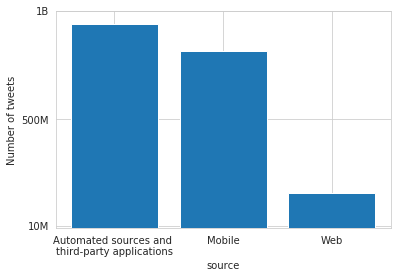

In [193]:
plt.bar(range(3),[automated_sources,mobile,web])
plt.xticks(range(3),['Automated sources and \nthird-party applications','Mobile','Web'])
plt.yticks([10000000,500000000,1000000000],['10M','500M','1B'])
plt.xlabel('source')
plt.ylabel('Number of tweets')

Text(0, 0.5, 'number of tweets posted by such users')

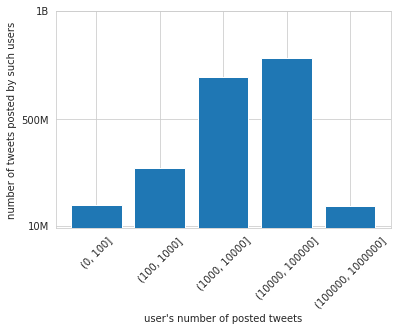

In [195]:
n_tweets = stats_dict['user_n_tweets'].groupby(pd.cut(stats_dict['user_n_tweets'].index,
                                           [0,100,1000,10000,100000,1000000])).sum()
plt.bar(range(5),n_tweets.values)
plt.xticks(range(5),n_tweets.index, rotation = 45)
plt.yticks([10000000,500000000,1000000000],['10M','500M','1B'])
plt.xlabel('user\'s number of posted tweets')
plt.ylabel('number of tweets posted by such users')

In [63]:
[math.exp(i) for i in range(10)]

[1.0,
 2.718281828459045,
 7.38905609893065,
 20.085536923187668,
 54.598150033144236,
 148.4131591025766,
 403.4287934927351,
 1096.6331584284585,
 2980.9579870417283,
 8103.083927575384]

In [65]:
bins = [1.0,
 3,
 7,
 20,
 55,
 148,
 403,
 1097,
 2981,
 8103]

In [67]:
len(bins)

10

Text(0, 0.5, 'number of tweets posted by such users')

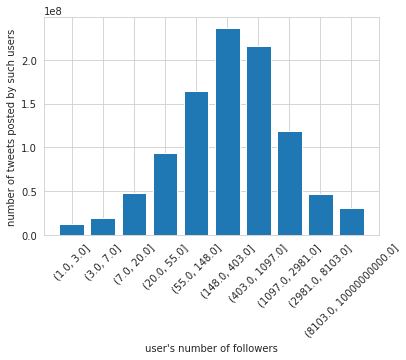

In [71]:
n_tweets = stats_dict['user_n_followers'].groupby(pd.cut(stats_dict['user_n_followers'].index,
                                           [1.0,
 3,
 7,
 20,
 55,
 148,
 403,
 1097,
 2981,
 8103,10000000000])).sum()
plt.bar(range(10),n_tweets.values)
plt.xticks(range(10),n_tweets.index, rotation = 45)
#plt.yticks([10000000,500000000,1000000000],['10M','500M','1B'])
plt.xlabel('user\'s number of followers')
plt.ylabel('number of tweets posted by such users')

Text(0, 0.5, 'number of tweets posted by such users')

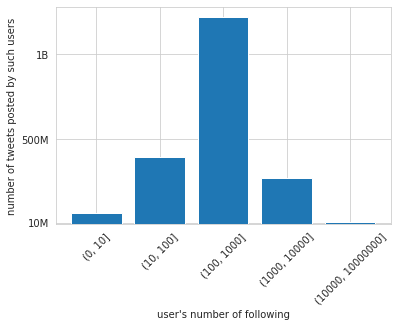

In [197]:
n_tweets = stats_dict['user_n_following'].groupby(pd.cut(stats_dict['user_n_following'].index,
                                           [0,10,100,1000,10000,10000000])).sum()
plt.bar(range(5),n_tweets.values)
plt.xticks(range(5),n_tweets.index, rotation = 45)
plt.yticks([10000000,500000000,1000000000],['10M','500M','1B'])
plt.xlabel('user\'s number of following')
plt.ylabel('number of tweets posted by such users')

Text(0, 0.5, 'number of tweets posted by such users')

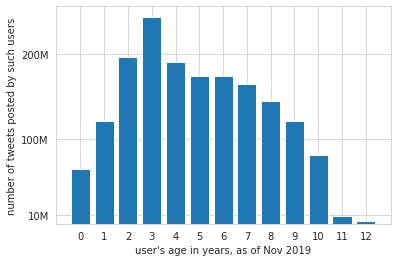

In [203]:


n_tweets = stats_dict['user_age_weeks'].groupby(pd.cut(stats_dict['user_age_weeks'].index,
                                           np.array(range(14))*52)).sum()
plt.bar(range(len(n_tweets)),n_tweets.values)
plt.xticks(range(len(n_tweets)))
plt.yticks([10000000,100000000,200000000],['10M','100M','200M'])
plt.xlabel('user\'s age in years, as of Nov 2019')
plt.ylabel('number of tweets posted by such users')


